# Title

This Notebook...

## Initialization

### Imports

In [1]:
import numpy
import matplotlib.pyplot

import logging
import io
import re
import ast

import sys
sys.path.append("../")
import congestionfinder
import congestionfinder.bpsdetector
import congestionfinder.road
import congestionfinder.detection
import congestionfinder.speedflow
import congestionfinder.congestion
import patchfinder.patch

### Logging

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(formatter)
logger.addHandler(consoleHandler)

class PlotFilter(logging.Filter):
    def filter(self, record):
        return "Found patches:" in record.getMessage()

log_capture_string = io.StringIO()
variableHandler = logging.StreamHandler(log_capture_string)
variableHandler.addFilter(PlotFilter())
logger.addHandler(variableHandler)

## Classes

In [3]:
bpsDetector = congestionfinder.bpsdetector.BPSDetector("00D00C03405B18200005")
print(bpsDetector)

bpsCode: 00D00C03405B18200005 | roadNumber: 12 | hectometer: 208 | additionalMeters: 91


In [4]:
road = congestionfinder.road.Road(12)
road.addBPSDetector(bpsDetector)
print(road)
road.indexDetectorSpaces()
print(road.getSpaceToSpaceIndex())

roadNumber: 12 | len(bpsDetectors): 1 | len(spaceToSpaceIndex): 0
{20891: 0}


In [5]:
detection = congestionfinder.detection.Detection("00D00C03405B18200005", 1234, 1440, 120, 17)
print(detection)

code: 00D00C03405B18200005 | space: 1234 | time: 1440 | speed: 120 | flow: 17


## Roads

In [6]:
roads = congestionfinder.road.parseBPSCodesToRoads(["10D00204D037D007000B", "10D002051800D0070013", "10D002057000D007000F"])
for value in roads.values():
    value.indexDetectorSpaces()

2017-12-18 13:16:51,359 - DEBUG - Starting parseBPSCodesToRoads()
2017-12-18 13:16:51,360 - DEBUG - Ending parseBPSCodesToRoads()


In [7]:
for value in sorted(roads.values(), key = lambda x:len(x.getBPSDetectors())):
    print(value)

roadNumber: 2 | len(bpsDetectors): 3 | len(spaceToSpaceIndex): 3


## Speed and Flows

In [8]:
detections = []
detections.append(congestionfinder.detection.Detection("10D00204D037D007000B", 30855, 1, 80, 17))
detections.append(congestionfinder.detection.Detection("10D00204D037D007000B", 30855, 2, 70, 16))
detections.append(congestionfinder.detection.Detection("10D00204D037D007000B", 30855, 3, 75, 17))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 1, 40, 10))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 2, 55, 18))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 3, 35, 12))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 1, 70, 19))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 2, 85, 14))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 3, 100, 19))

In [9]:
speeds, flows, minSpaceIndex, maxSpaceIndex, minTimeIndex, maxTimeIndex = congestionfinder.speedflow.parseDetectionsToSpeedsAndFlows(detections, roads[2])

2017-12-18 13:16:54,434 - DEBUG - Starting parseDetectionsToSpeedFlows()
2017-12-18 13:16:54,435 - DEBUG - Ending parseDetectionsToSpeedFlows()


(3, 3)
(3, 3)
0
2
1
3


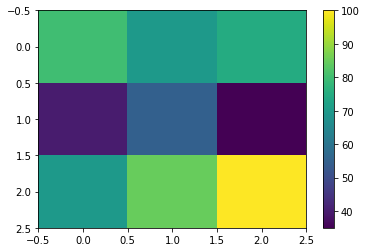

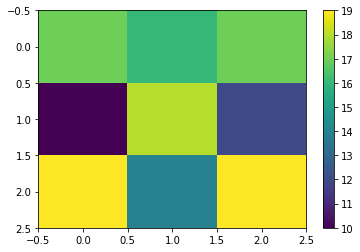

In [10]:
print(speeds.shape)
print(flows.shape)
print(minSpaceIndex)
print(maxSpaceIndex)
print(minTimeIndex)
print(maxTimeIndex)
matplotlib.pyplot.imshow(speeds, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flows, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [11]:
speedsHighFlow, flowsHighFlow, maskHighFlow = congestionfinder.speedflow.removeLowFlowTimes(speeds, flows) ## Do something with Mask

2017-12-18 13:16:56,779 - DEBUG - Starting removeLowFlowTimes()
2017-12-18 13:16:56,781 - DEBUG - Ending removeLowFlowTimes()


(3, 3)
(3, 3)
1.0


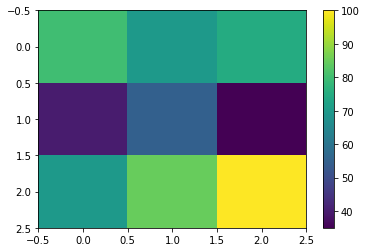

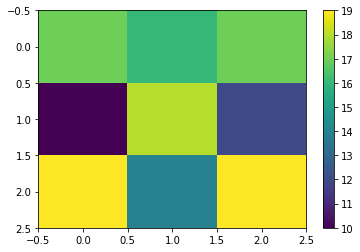

In [12]:
print(speedsHighFlow.shape)
print(flowsHighFlow.shape)
print(sum(maskHighFlow) / (sum(maskHighFlow) + sum(~maskHighFlow)))
matplotlib.pyplot.imshow(speedsHighFlow, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flowsHighFlow, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [13]:
speedsWorkingDetectors, flowsWorkingDetectors, maskWorkingDetectors = congestionfinder.speedflow.removeMissingDetectors(speeds, flows) ## Do something with Mask

2017-12-18 13:16:58,497 - DEBUG - Starting removeMissingDetectors()
2017-12-18 13:16:58,499 - DEBUG - Ending removeMissingDetectors()


(3, 3)
(3, 3)
1.0


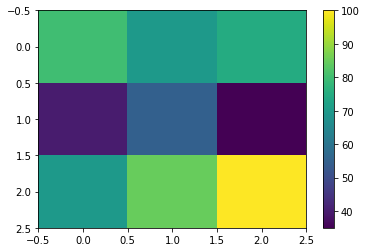

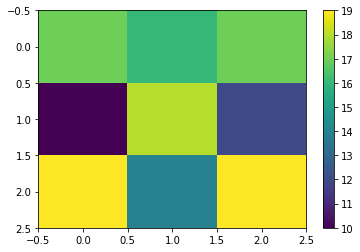

In [14]:
print(speedsWorkingDetectors.shape)
print(flowsWorkingDetectors.shape)
print(sum(maskWorkingDetectors) / (sum(maskWorkingDetectors) + sum(~maskWorkingDetectors)))
matplotlib.pyplot.imshow(speedsWorkingDetectors, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flowsWorkingDetectors, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

## Congestion

In [15]:
speedThreshold = 65
flowThreshold = 40
congestions = congestionfinder.congestion.parseSpeedFlowsToCongestions(speedsWorkingDetectors, flowsWorkingDetectors, speedThreshold, flowThreshold)

2017-12-18 13:17:01,448 - DEBUG - Starting parseSpeedFlowsToCongestions()
2017-12-18 13:17:01,449 - DEBUG - Ending parseSpeedFlowsToCongestions()


(3, 3)


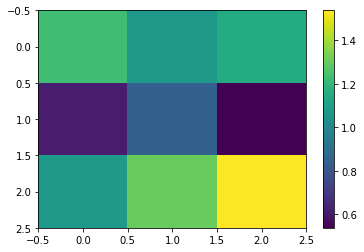

In [16]:
print(congestions.shape)
matplotlib.pyplot.imshow(congestions, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [17]:
congestions[1, 1] = numpy.nan
congestionsWithoutMissingValues = congestionfinder.congestion.interpolateMissingValues(congestions)

2017-12-18 13:17:02,636 - DEBUG - Starting interpolateMissingValues()
2017-12-18 13:17:02,651 - DEBUG - Ending interpolateMissingValues()


(3, 3)


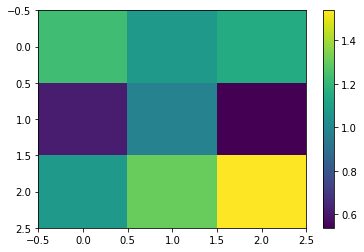

In [18]:
print(congestionsWithoutMissingValues.shape)
matplotlib.pyplot.imshow(congestionsWithoutMissingValues, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [19]:
spaceSmoothing = 1
timeSmoothing = 2
congestionsSmoothed = congestionfinder.congestion.applySmoothingFilter(congestionsWithoutMissingValues, spaceSmoothing, timeSmoothing)

2017-12-18 13:17:04,122 - DEBUG - Starting applySmoothingFilter()
2017-12-18 13:17:04,124 - DEBUG - Ending applySmoothingFilter()


(3, 3)


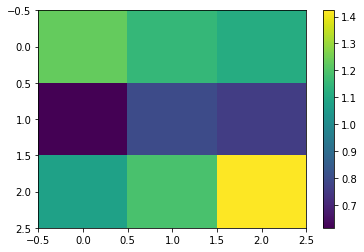

In [20]:
print(congestionsSmoothed.shape)
matplotlib.pyplot.imshow(congestionsSmoothed, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

## Patch Finder

In [21]:
testDataArray = numpy.random.rand(16,9)
testBooleanArray = testDataArray >= 0.9
print(testBooleanArray)

[[False False False  True False False False False False]
 [False False False  True False False False False False]
 [False  True False False  True False False False False]
 [False False False False False False  True False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [ True False  True  True False False False False False]
 [False False False  True  True False False False False]
 [False False False False False  True False False False]
 [False False False False False False False  True False]
 [False  True False False  True False  True False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False  True False  True False False False]]


In [22]:
patches = patchfinder.patch.findPatches(testBooleanArray)

2017-12-18 13:17:13,633 - DEBUG - Starting findPatches()
2017-12-18 13:17:13,634 - DEBUG - Direction: 0
2017-12-18 13:17:13,635 - DEBUG - Starting scanForBoundaries()
2017-12-18 13:17:13,636 - DEBUG - Found start: 0
2017-12-18 13:17:13,636 - DEBUG - Found stop: 7
2017-12-18 13:17:13,637 - DEBUG - Ending scanForBoundaries()
2017-12-18 13:17:13,638 - DEBUG - Found patches: [[0, 15, 0, 7]]
2017-12-18 13:17:13,639 - DEBUG - length: 1| parentLength: 0
2017-12-18 13:17:13,640 - DEBUG - Scanning children...
2017-12-18 13:17:13,641 - DEBUG - Child: 0
2017-12-18 13:17:13,642 - DEBUG -   Starting findPatches()
2017-12-18 13:17:13,643 - DEBUG -   Direction: 1
2017-12-18 13:17:13,644 - DEBUG -   Starting scanForBoundaries()
2017-12-18 13:17:13,644 - DEBUG -   Found start: 0
2017-12-18 13:17:13,645 - DEBUG -   Found stop: 3
2017-12-18 13:17:13,647 - DEBUG -   Found start: 6
2017-12-18 13:17:13,648 - DEBUG -   Found stop: 10
2017-12-18 13:17:13,649 - DEBUG -   Found start: 15
2017-12-18 13:17:13,650

2017-12-18 13:17:13,770 - DEBUG -     Scanning children...
2017-12-18 13:17:13,771 - DEBUG -     Child: 0
2017-12-18 13:17:13,773 - DEBUG -       Starting findPatches()
2017-12-18 13:17:13,774 - DEBUG -       Direction: 1
2017-12-18 13:17:13,775 - DEBUG -       Starting scanForBoundaries()
2017-12-18 13:17:13,776 - DEBUG -       Length is one
2017-12-18 13:17:13,777 - DEBUG -       Ending scanForBoundaries()
2017-12-18 13:17:13,778 - DEBUG -       Found patches: [[15, 15, 3, 3]]
2017-12-18 13:17:13,779 - DEBUG -       length: 1| parentLength: 2
2017-12-18 13:17:13,779 - DEBUG -       Scanning children...
2017-12-18 13:17:13,780 - DEBUG -       Child: 0
2017-12-18 13:17:13,783 - DEBUG -         Starting findPatches()
2017-12-18 13:17:13,784 - DEBUG -         Direction: 0
2017-12-18 13:17:13,785 - DEBUG -         Starting scanForBoundaries()
2017-12-18 13:17:13,786 - DEBUG -         Length is one
2017-12-18 13:17:13,787 - DEBUG -         Ending scanForBoundaries()
2017-12-18 13:17:13,788

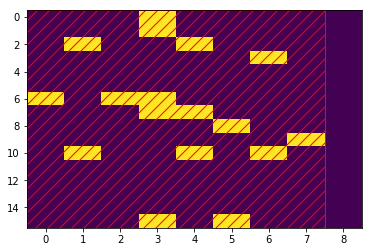

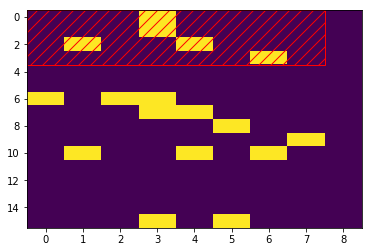

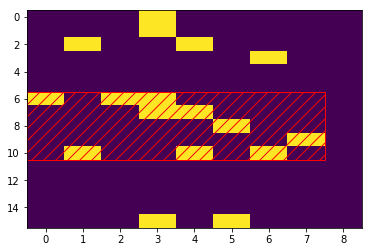

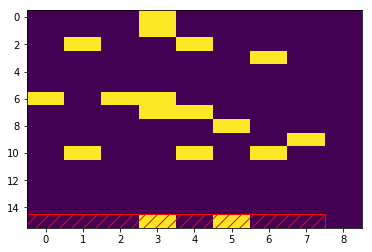

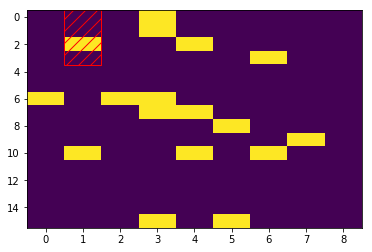

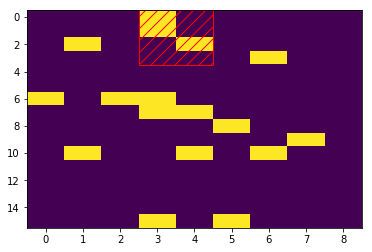

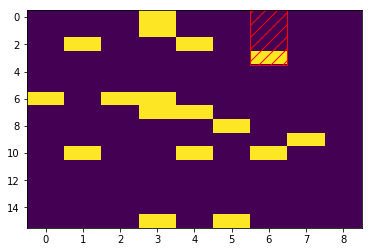

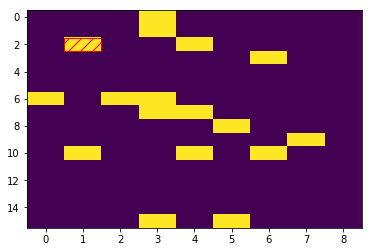

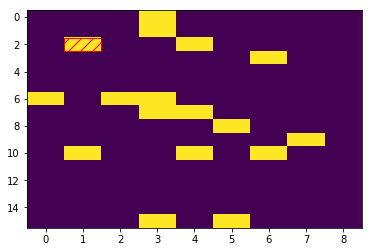

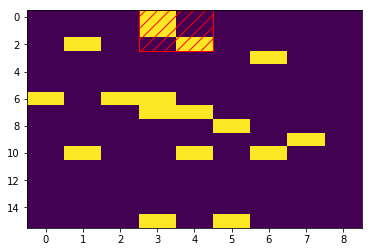

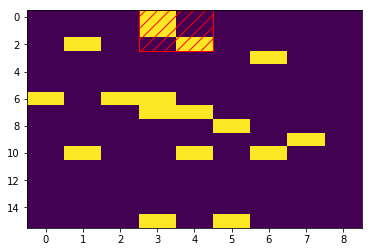

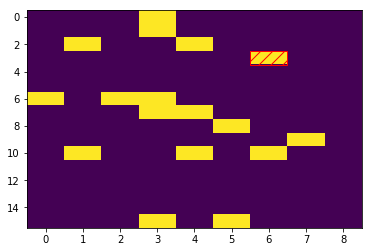

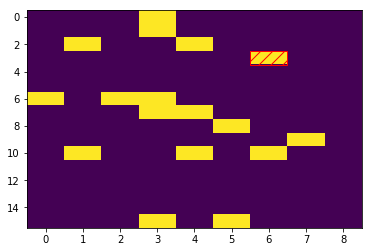

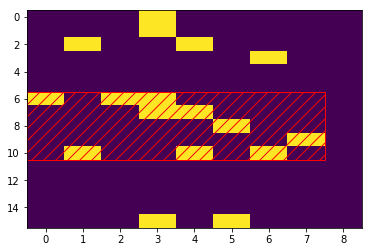

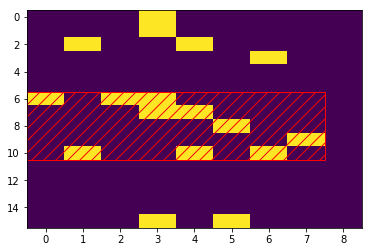

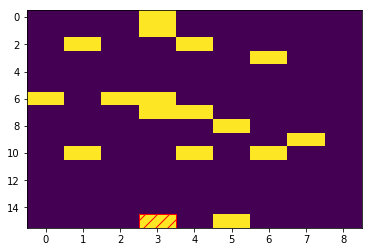

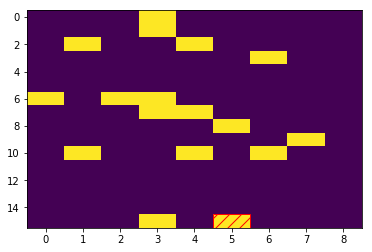

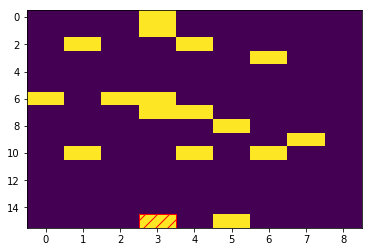

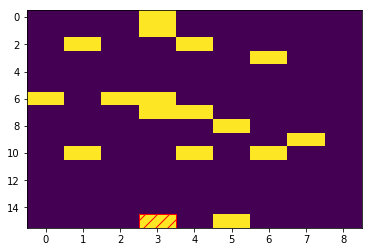

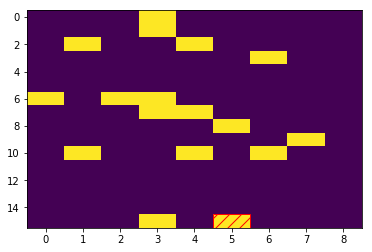

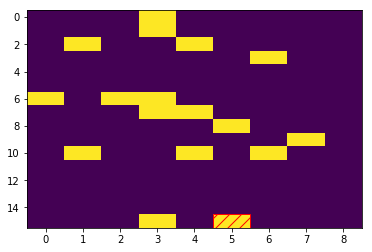

In [23]:
matches = re.findall("\[\d*, \d*, \d*, \d*\]", log_capture_string.getvalue())
for match in matches:
    array = ast.literal_eval(match)
    patch = patchfinder.patch.Patch(array[0], array[1], array[2], array[3])
    congestionfinder.congestion.plotCongestionsWithPatches(testBooleanArray, [patch])

In [24]:
for patch in patches:
    print(patch)

xStart: 2 | xEnd: 2 | yStart: 1 | yEnd: 1
xStart: 0 | xEnd: 2 | yStart: 3 | yEnd: 4
xStart: 3 | xEnd: 3 | yStart: 6 | yEnd: 6
xStart: 6 | xEnd: 10 | yStart: 0 | yEnd: 7
xStart: 15 | xEnd: 15 | yStart: 3 | yEnd: 3
xStart: 15 | xEnd: 15 | yStart: 5 | yEnd: 5


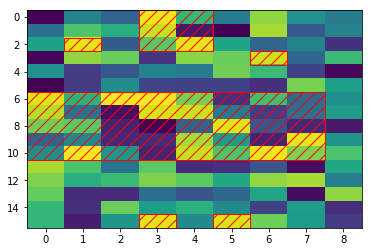

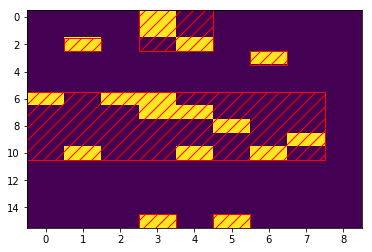

In [25]:
congestionfinder.congestion.plotCongestionsWithPatches(testDataArray, patches)
congestionfinder.congestion.plotCongestionsWithPatches(testBooleanArray, patches)

In [28]:
patchesFiltered = patchfinder.patch.filterLargePatches(patches, 1)

2017-12-18 13:17:34,497 - DEBUG - Starting filterLargePatches()
2017-12-18 13:17:34,498 - DEBUG - Ending filterLargePatches()


In [29]:
for patch in patchesFiltered:
    print(patch)

xStart: 0 | xEnd: 2 | yStart: 3 | yEnd: 4
xStart: 6 | xEnd: 10 | yStart: 0 | yEnd: 7


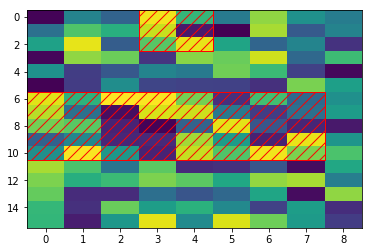

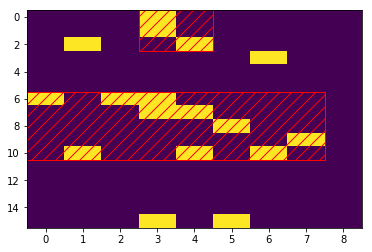

In [30]:
congestionfinder.congestion.plotCongestionsWithPatches(testDataArray, patchesFiltered)
congestionfinder.congestion.plotCongestionsWithPatches(testBooleanArray, patchesFiltered)

In [32]:
marginSpace = 2
marginTime = 1
minSpaceIndex = 0
maxSpaceIndex = 15
minTimeIndex = 0
maxTimeIndex = 8
patchesWithMargins = congestionfinder.speedflow.addMargins(patchesFiltered, marginSpace, marginTime, minSpaceIndex, maxSpaceIndex, minTimeIndex, maxTimeIndex)

2017-12-18 13:17:45,919 - DEBUG - Starting addMargins()
2017-12-18 13:17:45,920 - DEBUG - Ending addMargins()


In [33]:
for patch in patchesWithMargins:
    print(patch)

xStart: 0 | xEnd: 4 | yStart: 2 | yEnd: 5
xStart: 4 | xEnd: 12 | yStart: 0 | yEnd: 8


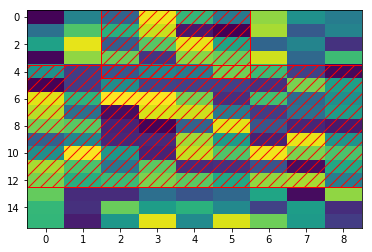

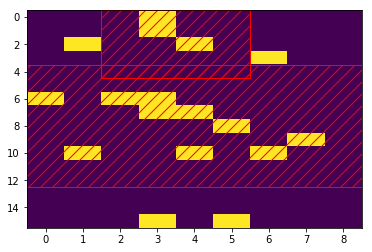

In [34]:
congestionfinder.congestion.plotCongestionsWithPatches(testDataArray, patchesWithMargins)
congestionfinder.congestion.plotCongestionsWithPatches(testBooleanArray, patchesWithMargins)

End of Notebook